In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
import numpy as np
import matplotlib.pylab as plt
import detectron2
import cv2
import os
import pathlib
import json
import random
from PIL import Image, ImageDraw2
import pandas as pd
import torchvision
from torchvision import transforms
import torch
import shutil
import glob

In [3]:
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

### Steps

* dataset generation with one logo
    *  logo -> transform -> overlay on background. bbox known (img dimensions)
    
    * logo with bbox -> transform img and bbox (imgaug)

* exporting to onnx and make it work with existing code

## Dataset Generation

* Offline

    * Generate N arbitrary colored backgrounds (DONE)

    * Transform transparent logo (DONE)
    
    * Overlay transformed and transparent logo onto background (DONE)
    
    * Save image and bounding box (DONE)

In [4]:
def generate_background_image(color_center, color_edge, size=(512,512)):
    #distance calculation
    row_idx = np.repeat(np.arange(0, size[0]), size[1], axis=0).reshape(size)
    col_idx = np.repeat(np.arange(0, size[1]), size[0], axis=0).reshape((size[1], size[0])).T    
    
    center = (size[0]/2, size[1]/2)
    dist = np.zeros(size)
    dist = np.sqrt((row_idx - center[0])**2 + (col_idx - center[1])**2)
    max_dist = np.max(dist)
    dist /= max_dist    
    
    #colors
    r = color_edge[0] * dist + color_center[0] * (1-dist)
    g = color_edge[1] * dist + color_center[1] * (1-dist)
    b = color_edge[2] * dist + color_center[2] * (1-dist)    
    
    #check artifacts with Image.fromarray()
    img = Image.new('RGBA', size)
    for y in range(size[1]):
        for x in range(size[0]):
            img.putpixel((x,y), (int(r[x,y]), int(g[x,y]), int(b[x,y])))
    
    return img

def retrieve_background_image(LOC):
    raise NotImplementedError

def make_logo_transparent(logo, threshold_color=[200,200,200]):
    logo = logo.convert('RGBA')
    data = logo.getdata()
    
    data_alpha = []
    for pixel in data:
        #if pixel[0]>200 and pixel[1]>200 and pixel[2]>200:
        if pixel[0]>threshold_color[0] and pixel[1] > threshold_color[1] and pixel[2] > threshold_color[2]:
            data_alpha.append((pixel[0], pixel[1], pixel[2], 0))
            #data_alpha.append((0,255,0,0))
        else:
            data_alpha.append((pixel[0], pixel[1], pixel[2], pixel[3]))
        
    logo.putdata(data_alpha)
    
    return logo

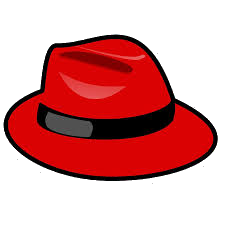

In [5]:
logo = Image.open('RHLOGO.jpg')
logo = make_logo_transparent(logo)
logo

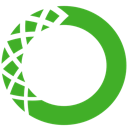

In [6]:
logo = Image.open('ANACONDALOGO.jpg')
logo = make_logo_transparent(logo)
logo = logo.resize((128,128))
logo

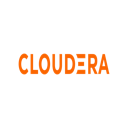

In [7]:
logo = Image.open('CLOUDERALOGO.jpg')
logo = make_logo_transparent(logo)
logo = logo.resize((128,128))
logo

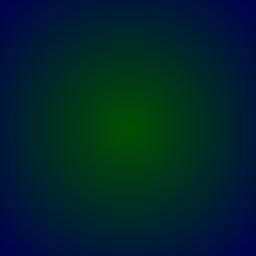

In [8]:
img = generate_background_image((0,80,0), (0,0,80), size=(256,256))
img

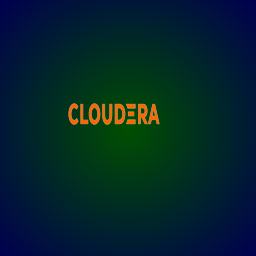

In [9]:
#test overlay
img_new = img.copy()
img_new.paste(logo, (50,50), logo)
img_new

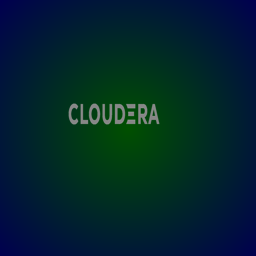

In [10]:
img_new = img.copy()
logo_tfs = torchvision.transforms.Grayscale()(logo)

img_new.paste(logo_tfs, (50,50), logo)
img_new

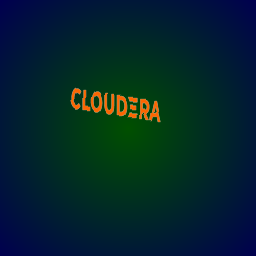

In [11]:
img_new = img.copy()
logo_tfs = torchvision.transforms.RandomAffine(45, translate=(0.1,0.1), scale=(1,1), shear=10)(logo)

img_new.paste(logo_tfs, (50,50), logo_tfs)
img_new


In [25]:
def generate_augmented_image(size=(512,512),
                             logo_file='CLOUDERALOGO.jpg',
                             N_tfms_to_apply=2,
                             low_frac=0.30,
                             high_frac=0.90):
        
    logo = Image.open(logo_file) #inefficient to open N times but okay for now

    #logo
    #step 1: get resize parameters
    #low_frac = 0.30
    #high_frac = 0.90
    frac0 = (np.random.random()*(high_frac-low_frac) + low_frac)
    frac1 = (np.random.random()*(high_frac-low_frac) + low_frac)
    logo_size = (int(frac0*size[0]), int(frac1*size[1]))

    #logo_size = (128,128) #introduce some randomness

    #step 2: get mask and apply resizing
    logo = make_logo_transparent(logo)
    logo = logo.resize(logo_size)

    #step 3: apply transformations
    tfms_list = [                
                    transforms.RandomRotation(45, expand=False, fill=255),
                    #transforms.RandomAffine(0, translate=(0.3,0.3)), #for truncations
                    transforms.RandomAffine(0, shear=(30,30))
                ]

    N_tfms = len(tfms_list)

    logo_tfms = logo.copy()
    for i in range(N_tfms_to_apply): #apply N transformations
        logo_tfms = tfms_list[np.random.randint(N_tfms)](logo_tfms)
        #logo_tfms = make_logo_transparent(logo_tfms)

    logo_tfms = make_logo_transparent(logo_tfms)

    #step 4: background image 
    colors = [(255,0,0), (0,255,0), (0,0,255), (128,0,0), (0,128,0), (0,0,128), 
              (0,0,0), (255,255,255), (128,128,128),        
              (255,255,0), (255,0,255), (0,255,255), (128,128,0), (128,0,128), (0,128,128)]
    N_colors = len(colors)

    colors_picked = np.array(colors)[np.random.randint(0, N_colors, size=2)]

    bkg = generate_background_image(colors_picked[0], colors_picked[1], size=size)

    #step 5: superimpose at random locations (actual translations)
    location_x = [0, bkg.size[0]-logo.size[0]]
    location_y = [0, bkg.size[1]-logo.size[1]]

    loc = (np.random.randint(*location_x), np.random.randint(*location_y))

    bkg.paste(logo_tfms, loc, logo_tfms)
    
    return bkg, (*size, *loc, loc[0] + logo_size[0], loc[1] + logo_size[1])

In [26]:
def visualize_bbox(img, bbox):
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    
    draw.rectangle([(bbox[2],bbox[3]), (bbox[4],bbox[5])], outline=128)
    
    return img_copy

In [27]:
def generate_random_string(N=6):
    return ''.join([chr(i) for i in np.random.randint(97,122,size=N)])

def generate_augmented_dataset(N_images,
                               size=(512,512),
                               low_frac=0.30,
                               high_frac=0.90,
                               logo_file='CLOUDERALOGO.jpg',
                               N_tfms_to_apply=2,
                               seed=None,
                               save_loc=None,
                               logo_name=None):
    
    if seed is not None: #should really figure out all torch seeds
        np.random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)    
    else:
        torch.backends.cudnn.deterministic = False
    
    img_list, bbox_list = [], []
    for i in range(N_images):
        img, bbox = generate_augmented_image(size, 
                                             logo_file, 
                                             N_tfms_to_apply,
                                             low_frac=low_frac,
                                             high_frac=high_frac)
        img_list.append(img)
        bbox_list.append(bbox)
        
    if save_loc is not None:
        if not os.path.exists(save_loc):
            pathlib.Path(save_loc).mkdir(parents=True, exist_ok=True)
        if logo_name is None:
            raise ValueError("Please enter logo_name if saving images")
                
        csv_fields = {'filename': [],
                      'width': [],
                      'height': [],
                      'class': [],
                      'xmin': [],
                      'ymin': [],
                      'xmax': [],
                      'ymax': []}
                
        for img, bbox in zip(img_list, bbox_list):
            img_name = f'{logo_name}_{generate_random_string()}.png'
            img.save(os.path.join(save_loc, img_name))
            
            csv_fields['filename'].append(os.path.join(save_loc, img_name))
            csv_fields['width'].append(bbox[0])
            csv_fields['height'].append(bbox[1])
            csv_fields['class'].append(logo_name)
            csv_fields['xmin'].append(bbox[2])
            csv_fields['ymin'].append(bbox[3])
            csv_fields['xmax'].append(bbox[4])
            csv_fields['ymax'].append(bbox[5])
            
        pd.DataFrame(csv_fields).to_csv(os.path.join(save_loc, f'{logo_name}.csv'), index=False)
    else:
        csv_fields = None
        
    return img_list, bbox_list, csv_fields

In [ ]:
img_list, bbox_list, csv_fields = generate_augmented_dataset(128, 
                                                             low_frac=0.20,
                                                             high_frac=0.40,
                                                             logo_file='RHLOGO.jpg',
                                                             save_loc='rhlogo/train',
                                                             logo_name='rhlogo')
img_list, bbox_list, csv_fields = generate_augmented_dataset(128, 
                                                             low_frac=0.20,
                                                             high_frac=0.40,
                                                             logo_file='RHLOGO.jpg',
                                                             save_loc='rhlogo/test',
                                                             logo_name='rhlogo')

In [ ]:
#convert csv to json
!python convert_csv_to_detectron.py rhlogo/train/rhlogo.csv rhlogo/train/data.json
!python convert_csv_to_detectron.py rhlogo/test/rhlogo.csv rhlogo/test/data.json

## Train Model

### Helper Functions

In [ ]:
def get_dicts(IMG_DIR):
    '''Returns a list of dicts - one for each image
    Each dict contains labels and bounding boxes
    
    Each folder (train, val, test) contains a data.json file
    '''

    path = os.path.join(IMG_DIR, 'data.json')
    dataset_dict = json.load(open(path))

    return dataset_dict

def register(IMG_DIR, class_names, subfolders=['train', 'test']):
    '''Register datasets for detectron2
    '''

    for d in subfolders:
        DatasetCatalog.register(f"{IMG_DIR}_{d}", lambda d=d: get_dicts(f'{IMG_DIR}/{d}'))
        MetadataCatalog.get(f"{IMG_DIR}_{d}").set(thing_classes=class_names)

def get_metadata(dataset_name):
    metadata = MetadataCatalog.get(dataset_name)

    return metadata        

def sample_plot(dataset_dict, metadata, LOC):
    #LOC = 'logos3/train'

    d = random.sample(dataset_dict, 1)[0]
    print(d)
    img = cv2.imread(os.path.join(LOC, d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    
def prepare_for_training(N_iter,
                         output_dir,
                         train_dataset_name,
                         N_classes,
                         start_training=False):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = N_iter    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = N_classes  # 4 classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)

    if start_training:
        trainer.train()

    return trainer, cfg    

def prepare_for_inference(cfg, test_dataset_name, threshold=0.70):
    print(f"Reading weights from output dir: {cfg.OUTPUT_DIR}")
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.DATASETS.TEST = (test_dataset_name, )
    predictor = DefaultPredictor(cfg)    

    return predictor

def infer_img(predictor, img_filename, metadata):
    img = cv2.imread(img_filename)
    outputs = predictor(img)

    v = Visualizer(img[:,:,::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    
    return outputs

In [ ]:
rhlogo_train = get_dicts('rhlogo/train')
register('rhlogo', ['rhlogo'], ['train', 'test'])
rhlogo_train_metadata = get_metadata('rhlogo_train')
sample_plot(rhlogo_train, rhlogo_train_metadata, 'rhlogo/train')
trainer, cfg = prepare_for_training(2000, 'rhlogo_output', 'rhlogo_train', 1, start_training=True)

trainer_discard, cfg = prepare_for_training(2000, 'rhlogo_output', 'rhlogo_train', 1, start_training=False)
predictor = prepare_for_inference(cfg, 'rhlogo_test', threshold=0.20)

infer_img(predictor, 'rhlogo_pvsvsf.png', rhlogo_train_metadata)

In [ ]:
rhlogo_train = get_dicts('rhlogo/train')
register('rhlogo', ['rhlogo'], ['train', 'test'])
rhlogo_train_metadata = get_metadata('rhlogo_train')
sample_plot(rhlogo_train, rhlogo_train_metadata, 'rhlogo/train')

In [ ]:
trainer, cfg = prepare_for_training(2000, 'rhlogo_output', 'rhlogo_train', 1, start_training=False)

In [ ]:
cfg.MODEL.DEVICE = "cpu"
predictor = prepare_for_inference(cfg, 'rhlogo_test', threshold=0.90)

In [ ]:
fig = plt.figure(figsize=(10,10))
infer_img(predictor, 'RHBKG4.jpg', rhlogo_train_metadata)

### Things to do:

1. add mAP (and others) as a metric

2. look for models with lower latency

3. more diverse backgrounds

4. add all 3 logos

5. test onnx export

6. clean and document code

7. (maybe) multiple logos on same background

### Train on 4 logos

#### Generate new dataset - remove translations from transformations list

In [30]:
N_images = 128
low_frac = 0.20
high_frac = 0.40

logo_file_list = ['RHLOGO.jpg',
                  'ANACONDALOGO.jpg',
                  'CLOUDERALOGO.jpg',
                  'SASLOGO.png']
name_list = [name.split('.')[0].replace('LOGO', '').lower() for name in logo_file_list]

In [31]:
for idx in range(len(logo_file_list)):
    logo_file = logo_file_list[idx]
    name = name_list[idx]
    
    print(f"Generating logos for {name}")
    
    for dataset in ['train', 'test']:
        img_list, bbox_list, csv_fields = generate_augmented_dataset(N_images, 
                                                                     low_frac=low_frac,
                                                                     high_frac=high_frac,
                                                                     logo_file=logo_file,
                                                                     save_loc=f'logo_detector/{name}/{dataset}',
                                                                     logo_name=name)

Generating logos for rh
Generating logos for anaconda
Generating logos for cloudera
Generating logos for sas


In [92]:
def check_combined_dataset(loc):
    
    label_file = os.path.join(loc, 'labels.csv')
    
    if not os.path.exists(label_file):
        raise ValueError("labels.csv doesn't exist. Please ensure loc argument is correct.")

    df_labels = pd.read_csv(label_file)
    csv_filenames = set(df_labels['filename'])
    
    filesystem_files = set(glob.glob(f"{loc}/*.png"))
    
    #ensures exactly same image files in filesystem tree and in csv files
    assert(len(csv_filenames.symmetric_difference(filesystem_files))==0)
    
    #ensure labels are correct between class column and image filenames
    N_correct = (df_labels['filename'].apply(lambda x: x.split('/')[-1].split('_')[0])==df_labels['class']).sum()
    
    assert(N_correct==df_labels.shape[0])
    
def combine_datasets(loc):
    '''Hacky - replace os by pathlib
    Add checks
    '''
    
    target_path = os.path.join(loc, 'combined')
    if os.path.exists(target_path):
        shutil.rmtree(target_path, ignore_errors=True)
    
    logo_list = os.listdir(loc) #rh,anaconda...
    dataset_type_list = os.listdir(os.path.join(loc, logo_list[0]))#train,test
    
    for dataset in dataset_type_list:#create combined/train, combined/test
        pathlib.Path(os.path.join(loc, 'combined', dataset)).mkdir(parents=True, exist_ok=True)
    
    #copy images over
    df_dict = {}
    for logo in logo_list: #rh
        for dataset in dataset_type_list: #train
            #csv files
            if dataset not in df_dict:
                df_dict[dataset] = []
            df_dict[dataset].append(pd.read_csv(os.path.join(loc, logo, dataset, f'{logo}.csv')))
            
            for img_file in glob.glob(os.path.join(loc, logo, dataset, '*.png')):
                shutil.copy2(img_file, os.path.join(loc, 'combined', dataset))
    
    def create_path(path, idx_to_exclude):
        return '/'.join([val if idx!=idx_to_exclude else "combined" for idx, val in enumerate(path.split('/'))]) 
    
    #process csvs
    for dataset in df_dict:
        df = pd.concat(df_dict[dataset], axis=0)
        
        df['filename'] = df['filename'].apply(lambda x: create_path(x, 1))
        
        df.to_csv(os.path.join(loc, 'combined', dataset, 'labels.csv'), index=False)
        
        check_combined_dataset(os.path.join(loc, 'combined', dataset))

In [91]:
combine_datasets('logo_detector')